In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def cluster_loss(z, centers):
    z = tf.reshape(z, [tf.shape(z)[0], 1, tf.shape(z)[1]])

    centers = tf.reshape(centers, [1, tf.shape(centers)[0], tf.shape(centers)[1]])
    partial = tf.math.pow(tf.squeeze(tf.norm(z - centers, ord='euclidean', axis=2)), 2)
    nominator = 1 / (1 + partial)
    denominator = tf.math.reduce_sum(1 / (1 + partial), axis=1)
    denominator = tf.reshape(denominator, [tf.shape(denominator)[0], 1])
    q = nominator / denominator
    q_norm = 1 - q
    q_norm = tf.math.log(q_norm + 0.00001)  # e for 0 logs
    return tf.reduce_sum(q_norm, axis=1)

In [8]:
c = [[0], [1]]
c = np.array(c, dtype=np.float32)

In [9]:
c.shape

(2, 1)

In [10]:
z = [[0.2], [0.4], [0.6], [0.7]]
z = np.array(z, dtype=np.float32)

In [11]:
z.shape

(4, 1)

In [12]:
loss = cluster_loss(z, c)

In [13]:
loss.shape

TensorShape([4])

Text(0.5, 1.0, 'centers=[0.], [1.]')

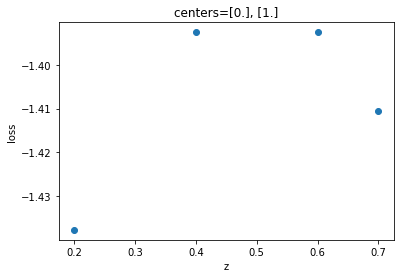

In [21]:
plt.scatter(z, loss)
plt.xlabel('z')
plt.ylabel('loss')
plt.title('centers={}, {}'.format(c[0], c[1]))

In [56]:
c = [[0, 0, 0, 0], [1, 1, 1, 1]]
c = np.array(c, dtype=np.float32)
z = [[0.2, 0.2, 0.2, 0.2], [0.1, 0.4, 0.3, 0.6], [0.8, 0.8, 0.4, 0.5], [0.5, 0.9, 0.4, 0.5], [0.5, 0.5, 0.5, 0.5]]
z = np.array(z, dtype=np.float32)

In [57]:
loss = cluster_loss(z, c)

Text(0.5, 1.0, 'centers=[0. 0. 0. 0.], [1. 1. 1. 1.]')

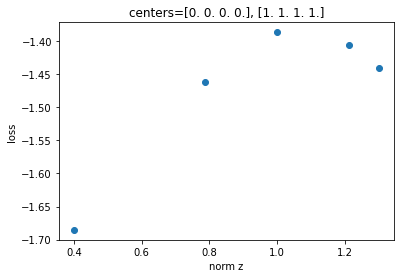

In [58]:
plt.scatter(tf.norm(z, ord='euclidean', axis=1), loss)
plt.xlabel('norm z')
plt.ylabel('loss')
plt.title('centers={}, {}'.format(c[0], c[1]))

In [69]:
c = [[0, 0], [1, 1]]
c = np.array(c, dtype=np.float32)
z = [[0.1, 0.2], [0.1, 0.4], [0.8, 0.8], [0.5, 0.9], [0.5, 0.5]]
z = np.array(z, dtype=np.float32)

In [70]:
loss = cluster_loss(z, c)
loss

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.5606002, -1.4801667, -1.5226996, -1.4460692, -1.3862543],
      dtype=float32)>

Text(0.5, 1.0, 'centers=[0. 0.], [1. 1.]')

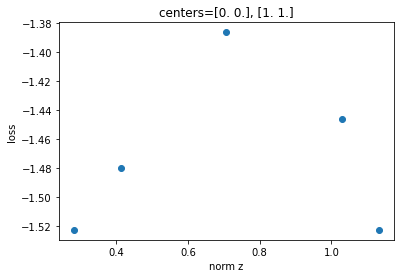

In [61]:
plt.scatter(tf.norm(z, ord='euclidean', axis=1), loss)
plt.xlabel('norm z')
plt.ylabel('loss')
plt.title('centers={}, {}'.format(c[0], c[1]))

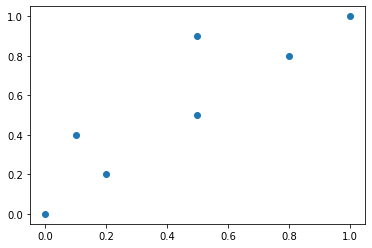

In [65]:
concat = np.concatenate((z, c))
plt.scatter(concat[:, 0], concat[:, 1])